- Se pravat 2 grafovi: prviot e so blok dijagonalna matrica na sosedstvo, reprezentira familii, vtoriot e vakov LFR_benchmark graf kade site nodes koi pripagjaat vo "community" na daden node ke se smetaat za pobliski prijateli, dodeka site ostanati vrski se smetaat za podalecni prijateli
- Vo familija ke ima najgolema shansa za zarazlivost, megju bliski prijateli pomala, megju podalecni najmala
- Moze da se poigra so "siva masa" kade so mnogu mal procent lugeto se zarazuvaat od nepoznat izvor (bez kontakt so drug covek)
- Da se definira distribucija na denovi za od exposed da se premine vo infected i od infected vo recovered
- Da se definira razlika pomegju exposed i infected node pri zarazuvanje na sosednite nodes (primer exposed gi zarazuva site, no infected zarazuva samo clenovi na familija, bidejki e izoliran)
- Mozebi da se napravi SEIRS model, bidejki lice koe ja prelezalo bolesta gi ima antitelata odredeno vreme, a potoa povtorno moze da se zarazi
- Dinamicka promena na gledanje so prijateli i ostanati vrski (primer na pocetok ne se pocituvaat merki i se gledame so niv sekoj den, koga ke stigne brojot na infected nad odreden threshold se voveduvaat odredeni merki, no tie ne mozat da traat predolgo radi ekonomski pricini, pa se olabavuvaat po odreden period itn.)
***

In [1]:
import itertools
import networkx as nx
import random as rn
import matplotlib.pyplot as plt
from copy import deepcopy

rn.seed(42)
colors = ["#313695", "#a50026", "#fee838", "#004529"]
status = ["susceptible", "exposed", "infected", "recovered"]

%matplotlib inline

In [2]:
def run_simulation(G, num_days, initial_exposed, incubation_period=7,
                   recovery_period=14, infection_rate=0.1, plot=False):
    num_nodes = len(G.nodes)
    exposed = [rn.randint(0, num_nodes-1) for i in range(initial_exposed)]
    infected = []
    recovered = []
    
    for i in exposed:
        G.nodes[i]["status"] = 1
    
    suspectible_ts = [num_nodes - initial_exposed]
    exposed_ts = [initial_exposed]
    infected_ts = [0]
    recovered_ts = [0]
    
    for i in range(num_days):
        new_exposed = []
        for j in range(num_nodes):
            G.nodes[j]["days"] = G.nodes[j]["days"] + 1
            # infected to recovered
            if G.nodes[j]["status"] == 2 and G.nodes[j]["days"] == recovery_period:
                G.nodes[j]["status"] = 3
                G.nodes[j]["days"] = 0
                infected.remove(j)
                recovered.append(j)
            # exposed to infected
            if G.nodes[j]["status"] == 1 and G.nodes[j]["days"] == incubation_period: 
                G.nodes[j]["status"] = 2
                G.nodes[j]["days"] = 0
                exposed.remove(j)
                infected.append(j)
        for j in exposed:
            neighbors = G.neighbors(j)
            for k in neighbors:
                if G.nodes[k]["status"] == 0:
                    r = rn.randint(1, 100)
                    if r < 100 * infection_rate:
                        G.nodes[k]["status"] = 1
                        G.nodes[k]["days"] = 0
                        new_exposed.append(k)
        exposed = exposed + new_exposed
        suspectible_ts.append(num_nodes - len(exposed) - len(infected) - len(recovered))
        exposed_ts.append(len(exposed))
        infected_ts.append(len(infected))
        recovered_ts.append(len(recovered))
        
    plot_seir(suspectible_ts, exposed_ts, infected_ts, recovered_ts, num_days + 1)
    if plot:
        plot_graph(G)

def generate_graph(num_nodes, tau1=2, tau2=5, mu=0.1, max_degree=15, average_degree=5,
                   min_community=6, max_community=30):
    G = nx.LFR_benchmark_graph(num_nodes, tau1, tau2, mu, average_degree, max_degree=max_degree,
                               min_community=min_community, max_community=max_community, seed=42)
    nx.set_node_attributes(G, 0, "status")
    nx.set_node_attributes(G, 0, "days")
    return add_families_to_graph(G, num_nodes)

def add_families_to_graph(F, num_population):
    # Used 2019 USA demographics to get these numbers
    num_family_members = [1, 2, 3, 4, 5, 6, 7]
    probabilities = [0.2837, 0.3451, 0.1507, 0.1276, 0.0578, 0.0226, 0.0125] 
    families = rn.choices(num_family_members, probabilities, k=num_population//2)
    n, i = 0, 0
    while n < num_population:
        if n + families[i] > num_population:
            k = num_population - n
        else:
            k = families[i]
        fam = [x for x in range(n, n+k)]
        edges = itertools.combinations(fam,2)
        F.add_edges_from(edges)
        for j in range(k):
            F.nodes[n+j]['family'] = fam
        n = n+k
        i = i+1
    return F

def plot_graph(G):
    fig, ax = plt.subplots(figsize=(18,10))
    node_color = [colors[x] for x in nx.get_node_attributes(G, "status").values()]
    pos = nx.spring_layout(G)
    for i in range(len(status)):
        node_subset = [x for x, y in G.nodes(data=True) if y["status"]==i]
        nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=node_subset, node_size=100,
                               node_color=colors[i], label=status[i], alpha=.75)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#a2a2a2", alpha=.75)
    plt.legend()
    
def plot_seir(sus, exp, inf, rec, num_days):
    fig = plt.figure(figsize=(18,10))
    plt.plot(range(num_days), sus, c=colors[0])
    plt.plot(range(num_days), exp, c=colors[1])
    plt.plot(range(num_days), inf, c=colors[2])
    plt.plot(range(num_days), rec, c=colors[3])
    plt.legend(status)
    plt.title("SEIR graph for simulation that lasted {} days".format(num_days))
    plt.show()

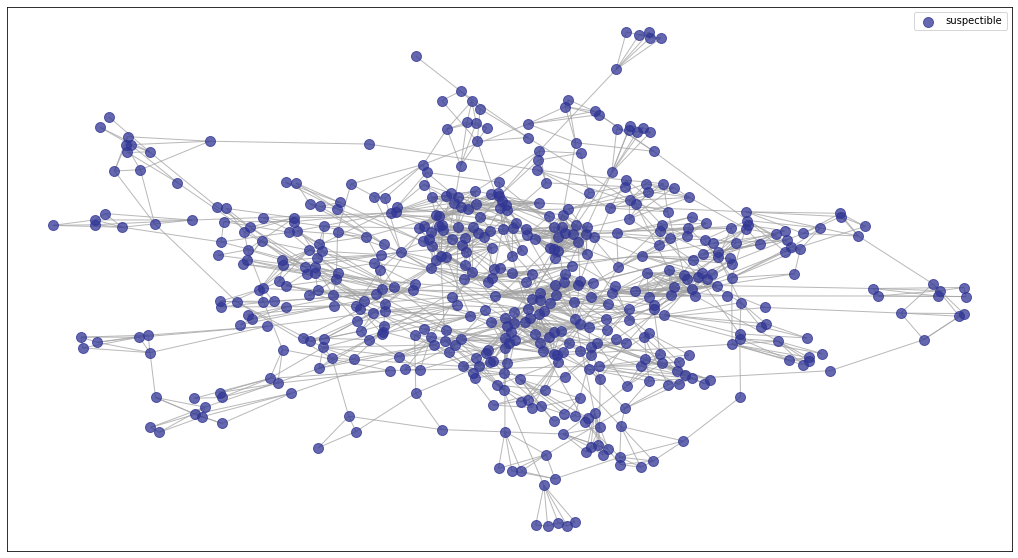

In [3]:
num_nodes = 501
G = nx.LFR_benchmark_graph(num_nodes, 2, 5, 0.1, max_degree=15, average_degree=5,
                           min_community=6, max_community=30, seed=42)
nx.set_node_attributes(G, 0, "status")
nx.set_node_attributes(G, 0, "days")
plot_graph(G)

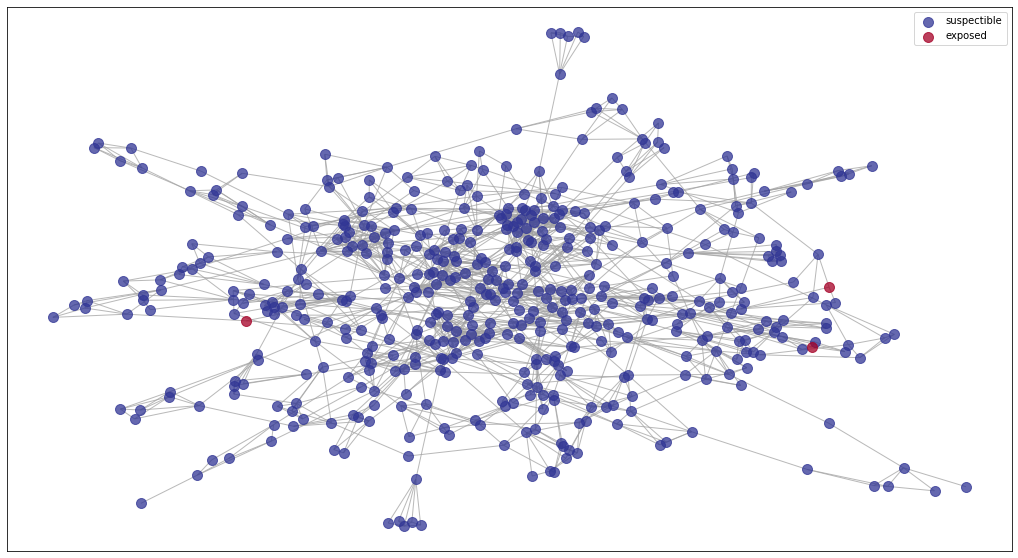

In [5]:
initial_exposed = 3
exposed = [rn.randint(0, num_nodes-1) for i in range(initial_exposed)]
infected = []
recovered = []
G_copy = deepcopy(G)
for i in exposed:
    G.nodes[i]["status"] = 1
plot_graph(G)

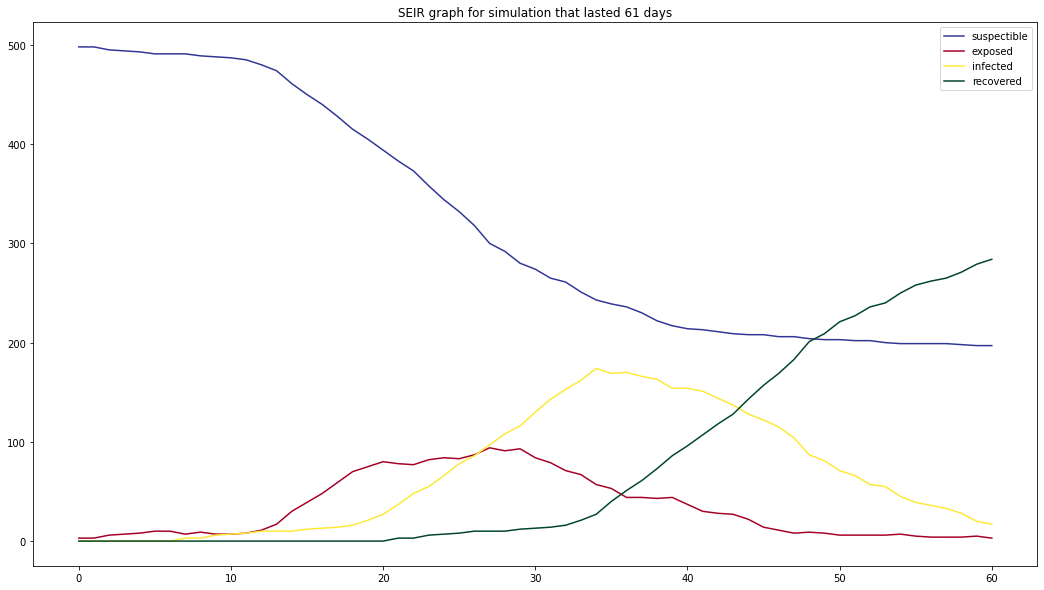

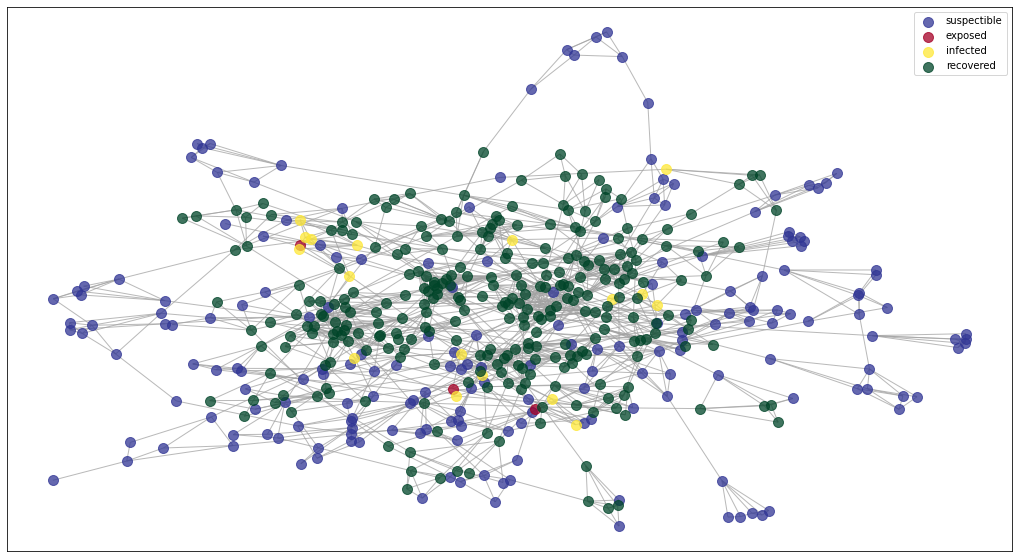

In [6]:
# define time series arrays
suspectible_ts = [num_nodes - initial_exposed]
exposed_ts = [initial_exposed]
infected_ts = [0]
recovered_ts = [0]

# define parameters for simulation
num_days = 60
incubation_period = 7 # distribution
recovery_period = 14  # distribution
infection_rate = 0.1 # 

# start simulation
for i in range(num_days):
    new_exposed = []
    for j in range(num_nodes):
        G.nodes[j]["days"] = G.nodes[j]["days"] + 1
        # infected to recovered
        if G.nodes[j]["status"] == 2 and G.nodes[j]["days"] == recovery_period:
            G.nodes[j]["status"] = 3
            G.nodes[j]["days"] = 0
            infected.remove(j)
            recovered.append(j)
        # exposed to infected
        if G.nodes[j]["status"] == 1 and G.nodes[j]["days"] == incubation_period: 
            G.nodes[j]["status"] = 2
            G.nodes[j]["days"] = 0
            exposed.remove(j)
            infected.append(j)
    for j in exposed:
        neighbors = G.neighbors(j)
        for k in neighbors:
            if G.nodes[k]["status"] == 0:
                r = rn.randint(1, 100)
                if r < 100 * infection_rate:
                    G.nodes[k]["status"] = 1
                    G.nodes[k]["days"] = 0
                    new_exposed.append(k)
    exposed = exposed + new_exposed
    suspectible_ts.append(num_nodes - len(exposed) - len(infected) - len(recovered))
    exposed_ts.append(len(exposed))
    infected_ts.append(len(infected))
    recovered_ts.append(len(recovered))
plot_seir(suspectible_ts, exposed_ts, infected_ts, recovered_ts, num_days + 1)
plot_graph(G)

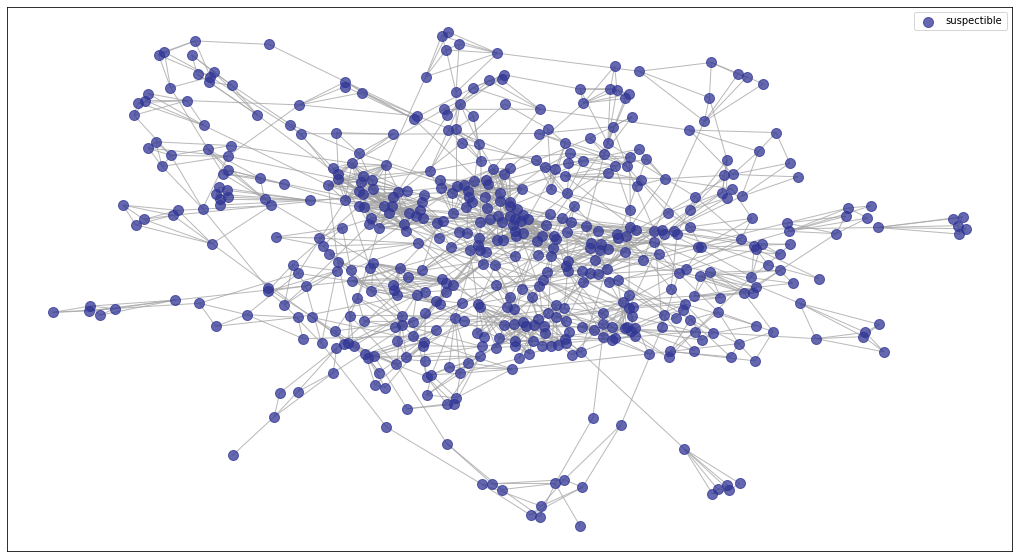

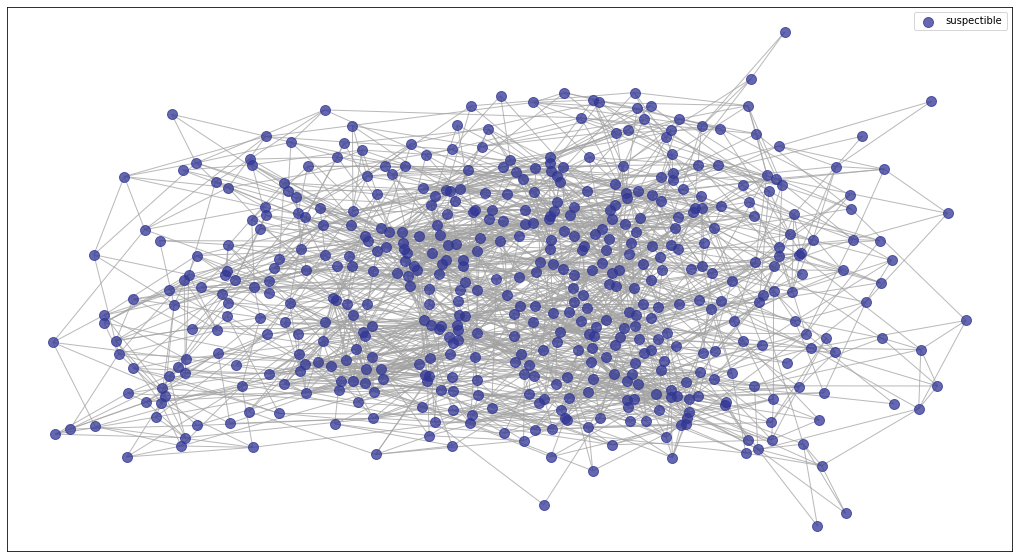

In [7]:
F = add_families_to_graph(deepcopy(G_copy), num_nodes)
plot_graph(G_copy)
plot_graph(F)

In [10]:
nx.get_node_attributes(F, 'family')

{0: [0, 1, 2],
 1: [0, 1, 2],
 2: [0, 1, 2],
 3: [3, 4, 5, 6],
 4: [3, 4, 5, 6],
 5: [3, 4, 5, 6],
 6: [3, 4, 5, 6],
 7: [7],
 8: [8],
 9: [9, 10, 11, 12],
 10: [9, 10, 11, 12],
 11: [9, 10, 11, 12],
 12: [9, 10, 11, 12],
 13: [13],
 14: [14, 15],
 15: [14, 15],
 16: [16, 17],
 17: [16, 17],
 18: [18],
 19: [19, 20, 21, 22],
 20: [19, 20, 21, 22],
 21: [19, 20, 21, 22],
 22: [19, 20, 21, 22],
 23: [23, 24],
 24: [23, 24],
 25: [25, 26, 27],
 26: [25, 26, 27],
 27: [25, 26, 27],
 28: [28, 29],
 29: [28, 29],
 30: [30, 31],
 31: [30, 31],
 32: [32, 33],
 33: [32, 33],
 34: [34, 35],
 35: [34, 35],
 36: [36, 37, 38, 39],
 37: [36, 37, 38, 39],
 38: [36, 37, 38, 39],
 39: [36, 37, 38, 39],
 40: [40, 41],
 41: [40, 41],
 42: [42, 43, 44, 45],
 43: [42, 43, 44, 45],
 44: [42, 43, 44, 45],
 45: [42, 43, 44, 45],
 46: [46, 47, 48],
 47: [46, 47, 48],
 48: [46, 47, 48],
 49: [49, 50],
 50: [49, 50],
 51: [51, 52],
 52: [51, 52],
 53: [53],
 54: [54],
 55: [55],
 56: [56, 57],
 57: [56, 57],
 58

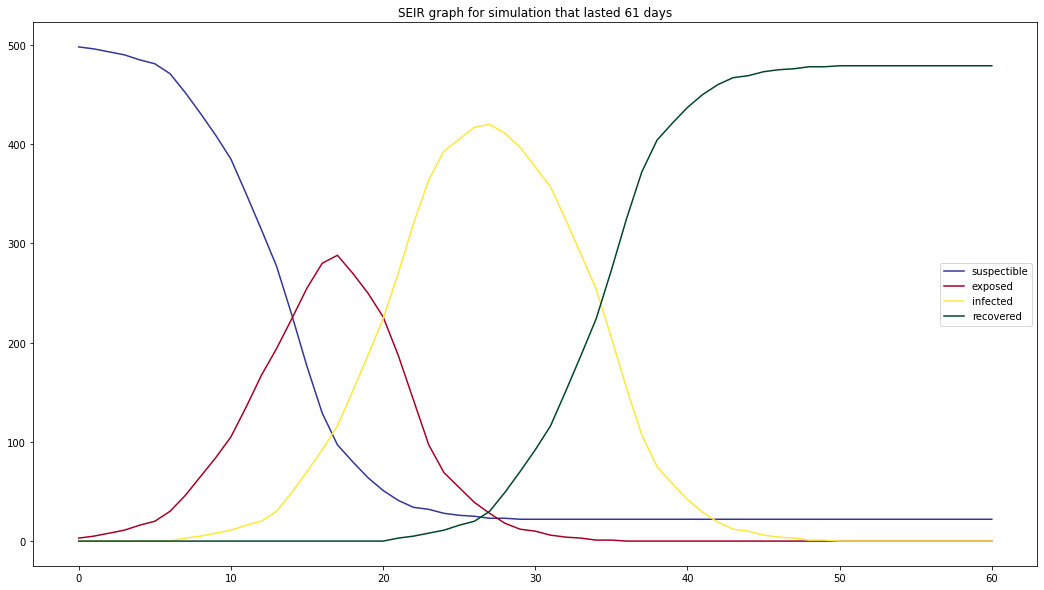

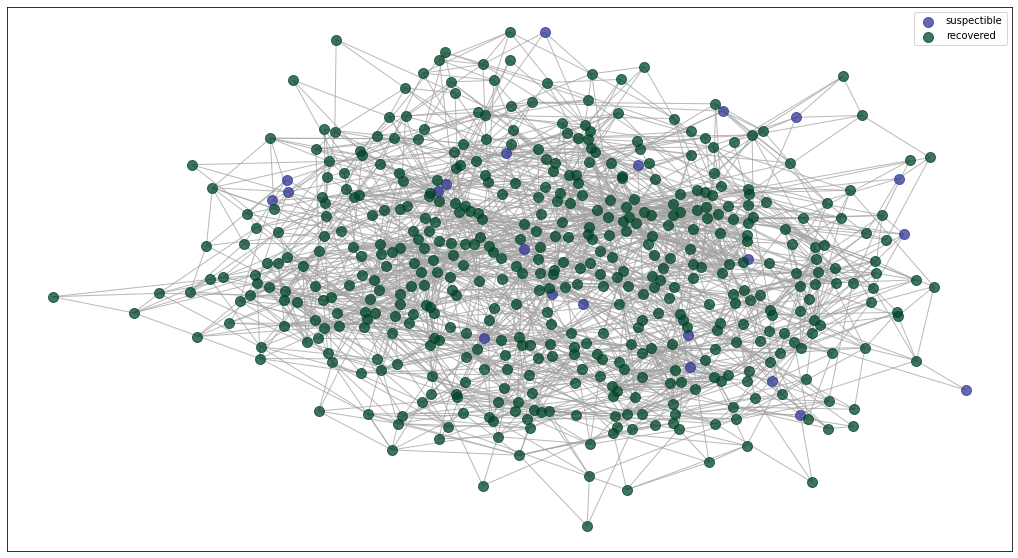

In [11]:
run_simulation(F, num_days=60, initial_exposed=3, plot=True)

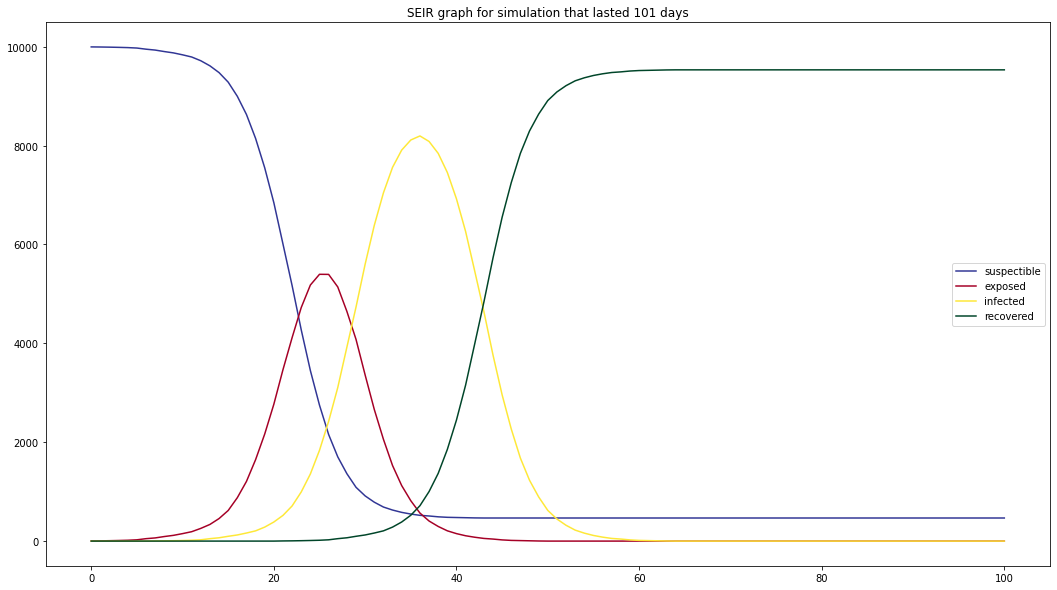

In [21]:
G = generate_graph(int(1e4))
run_simulation(deepcopy(G), num_days=100, initial_exposed=3)

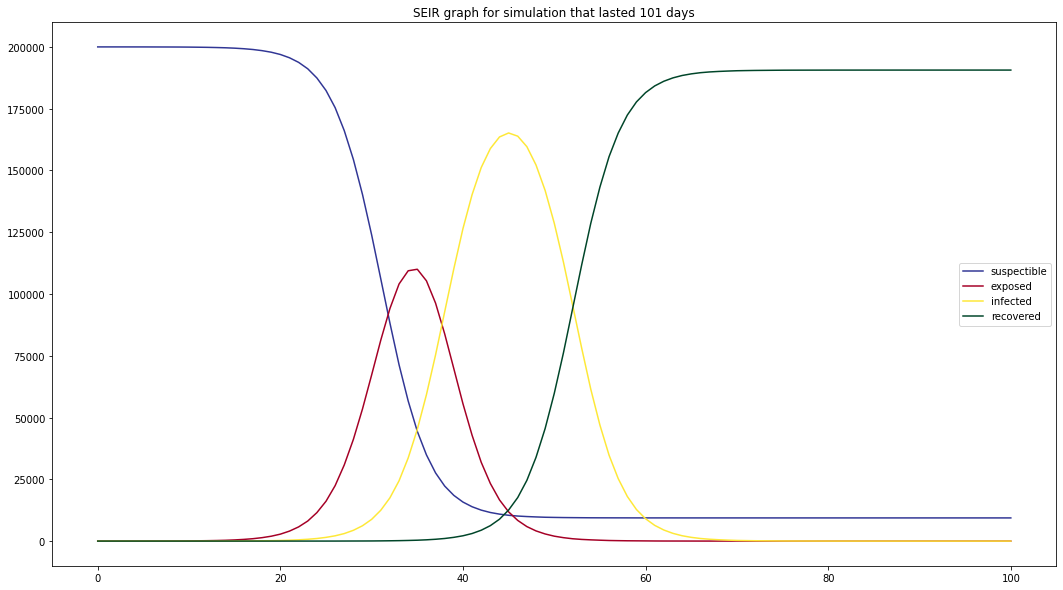

In [22]:
G = generate_graph(int(2e5))
run_simulation(deepcopy(G), num_days=100, initial_exposed=3)

***

In [27]:
sus = [x == 0 for x in nx.get_node_attributes(G, "status").values()]
print(sum(sus))

5752


In [ ]:
nx.get_node_attributes(G, "community")

In [12]:
community = [4, 29, 68, 211, 289, 374, 376]
l = list(nx.edges(G, community))
print("Edges between nodes in this community:")
for s, d in l:
    if s in community and d in community:
        print((s, d))
print("Edges to nodes outside of the community")
for s, d in l:
    if s not in community or d not in community:
        print((s, d))

Edges between nodes in this community:
(4, 68)
(4, 374)
(29, 289)
(29, 376)
(29, 374)
(68, 289)
(68, 376)
(68, 374)
(211, 211)
(211, 376)
(289, 376)
(289, 374)
(376, 376)
Edges to nodes outside of the community
(4, 55)
(211, 124)


In [13]:
display(F.nodes[0])

{'community': {0, 9, 74, 107, 172, 232, 245, 378},
 'status': 3,
 'days': 34,
 'family': [0, 1, 2]}